# Title

In this notebook, we present our experiments for the under review paper of ICDT [link]().

We also provide a framework for those who would like to reproduce our experiments or adapt its rationale to another use-case through the following steps:

- [Install and inport necessary data and modules.](#installation)
- [Using Pydantic, define Entities and Attributes.](#pydantic)
- [For each attribute in the external source, apply the mapping algorithm of its corresponding SDG entity. If a SDG Attribute is detected, extract relevant information for disaggregation.](#mapping)
- [Evaluate all predictions.](#evaluation)
- [Make collections of instantiated SDG Attributes to verify data quality and make observations.](#collection)
- [Calculate and visualize the 11.2.1 indicator.](#indicator)

<a id="installation"></a>
### Install and inport necessary data and modules.

For the GeographyArea entity, we imported and processed [French population census from INSEE since 2006](https://www.insee.fr/fr/information/2383410). We only kept the columns that stood the test of time (i.e. any introduction of an observation past 2006 or any discontinuation of an observation before 2020 has been removed). We centered our study to the region of Ile-de-France and indicated different levels of aggregation:

- geographyArea_0: IRIS, a subdivision of municipalities based on socio-economic distribution.
- geographyArea_1: Municipality.
- geographyArea_2: Department.
- geographyArea_3: Region.

For our illustrated example, we did not introduce any aggregation rules whatsoever as this will be the focus of future work. This notebook only allows spatial filtering along one of the geographyArea levels. We also used [IGN's geocoordinates files](https://data.iledefrance.fr/explore/dataset/iris/information).

For the PublicTransport entity, we scraped the [Ile-de-France Mobility database](https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/information/?disjunctive.id&disjunctive.route_long_name&location=8,48.71578,2.35526&basemap=jawg.streets) with the following spatial levels of aggregation:

- publicTransport_0: Station, the code identifier of the specific station.
- publicTransport_1: Network, the code identifier of the network the station is operated by.

In [1]:
%pip install --upgrade --quiet langchain langchain-openai matplotlib scikit-learn numpy gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
%mkdir external_source

In [3]:
!gdown "1RlGDu6A5JPWsHaD7tkrQaM8wy0JwLm1H" --output "external_source/GeographyArea.csv" --quiet
!gdown "1fqeyINP_S3pkaQJoHGfXxTBU8PPWm6KY" --output "external_source/GeographyArea.json" --quiet
!gdown "1nPIauXaIcVrYIKbCHF2ROCvo8v3yInAg" --output "external_source/PublicTransport.csv" --quiet
!gdown "1aB2pXjdbrcE4Rb-rtUQ4R0kt7r2dbk7e" --output "external_source/PublicTransport.json" --quiet

<a id="pydantic"></a>
### Using Pydantic, define Entities and Attributes.

In this section, we will define classes representing our SDGs Entities and Attributes.

We use [Pydantic](https://docs.pydantic.dev/latest/concepts/fields/) for its compatibility with [LangChain](https://python.langchain.com/docs/use_cases/tagging#pydantic) in information extraction and classification:

![Image of LangChain's information extraction](https://python.langchain.com/assets/images/tagging-93990e95451d92b715c2b47066384224.png)

It is important to provide extensive descriptions that will help generate a clear prompt for the LLM to interpret.

We hope in the future to provide a prompt that does not rely on fine-tuned examples or at the very least is not fine-tuned on the same dataset we are experimenting.

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Population(BaseModel):
    sex: str = Field(
        description="What gender is concerned by the column? For example 'femmes' means 'female' and 'hommes' means 'male'.",
        enum=["female", "male", None],
        default=None
    )
    age_lower_bound: int = Field(
        description="What is the minimal age considered by the column? For example 'de 25 ans à 35 ans' means that 25 is the lower bound.",
        default=None
    )
    age_upper_bound: int = Field(
        description="What is the maximal age considered by the column? For example 'de 25 ans à 35 ans' means that 35 is the lower bound.",
        default=None
    )
    disability: str = Field(
        description="Is disability concerned by the column?",
        enum=["yes", "no", None],
        default=None
    )

class GPSCoordinates(BaseModel):
    longitude: bool = Field(
        description="Is the column concerning the longitude?",
        default=False
    )
    latitude: bool = Field(
        description="Is the column concerning the latitude?",
        default=False
    )

class GeographyArea(BaseModel):
    attribute: str = Field(
        description="""Population Category: If the column calculates population numbers and is ONLY disaggregated by sex, age and disability, you should return the 'Population' category. If there is any additional information besides sex, age and disability DO NOT RETURN THE COLUMN, DO NOT TAKE ANY CHANCES.
        INCLUDE Postive examples would be "POP", "POPF15P" or "POPH1564", they ARE VALID columns because they only inform about sex, age and disability.
        DO NOT INCLUDE examples such as "NPER_RP_LOCHLMV" is NOT VALID, "SAL15P_INTERIM" is NOT VALID, "HACTOCC15P" is NOT VALID, "FNSCOL15P" is NOT VALID, "FACTOCC1524" is NOT VALID, "CHOM1564" is NOT VALID, "ACT1524" is NOT VALID. They ARE NOT valid columns because they add information that are out of scope. They can refer to housing status, working category or employment status. These are out of scope and must be removed. Any additionnal information besides sex, age and disability must be removed. Do not take any chances, if there is any information besides sex, age and disability, remove the column.
        GPSCoordinates Category: Columns containing geographical information such as latitude, longitude, or any other GPS-related data should be categorized as "GPSCoordinates".""",
        default=None,
        enum=[None, "Population", "GPSCoordinates"]
    )

class PublicTransport(BaseModel):
    attribute: str = Field(
        description="""If the column deals with the coordinates, and is only disaggregated according to either longitude or latitude, then return 'GPSCoordinates', if the column adds any information besides latitude or longitude, return None.
        In all other cases, return None.""",
        default=None,
        enum=[None, "GPSCoordinates"]
    )

In [5]:
from langchain_openai import AzureChatOpenAI # CHANGE ACCORDINGLY

llm = AzureChatOpenAI(
      temperature=0,
      azure_endpoint=#YOUR ENDPOINT,
      azure_deployment=#YOUR DEPLOYMENT,
      openai_api_key=#YOUR KEY,
      openai_api_version=#YOUR VERSION
)

In [6]:
from langchain.chains import create_tagging_chain_pydantic

chains = {
    "mapping": {
        "GeographyArea": create_tagging_chain_pydantic(GeographyArea, llm),
        "PublicTransport": create_tagging_chain_pydantic(PublicTransport, llm)
    },

    "disaggregation": {
        "Population": create_tagging_chain_pydantic(Population, llm),
        "GPSCoordinates": create_tagging_chain_pydantic(GPSCoordinates, llm)
    },

    "rules": {
        "Population": {
            "age": {"type": "list", "values": ["age_lower_bound", "age_upper_bound"]}
        }
    }
}

<a id="mapping"></a>
### For each attribute in the external source, apply the mapping algorithm of its corresponding SDG entity. If a SDG Attribute is detected, extract relevant information for disaggregation.

In this section, we will apply our predictions as described in the paper. For each attribute in the external source, we will try to map it to an attribute from the SDG entity. If the LLM finds a relationship, we will instantiate an object of the corresponding SDG attribute and try to fill its properties about disaggregation.

In [7]:
import json
import os
entities = [entity.split('.')[0] for entity in os.listdir('external_source') if '.json' in entity]

benchmark = {
    entity: json.load(open(f"external_source/{entity}.json")) for entity in entities
}

print(json.dumps(benchmark, indent=4))

{
    "PublicTransport": {
        "longitude": {
            "description": "Coordonn\u00e9es longitude de l'arr\u00eat (align\u00e9 avec le GTFS)",
            "source": "https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/information/?disjunctive.id&disjunctive.route_long_name&location=8,48.71578,2.35526&basemap=jawg.streets",
            "benchmark": {
                "entity": "PublicTransport",
                "attribute": "GPSCoordinates",
                "disaggregation": {
                    "longitude": true,
                    "latitude": false
                }
            }
        },
        "latitude": {
            "description": "Coordonn\u00e9es latitude de l'arr\u00eat (align\u00e9 avec le GTFS)",
            "source": "https://data.iledefrance-mobilites.fr/explore/dataset/arrets-lignes/information/?disjunctive.id&disjunctive.route_long_name&location=8,48.71578,2.35526&basemap=jawg.streets",
            "benchmark": {
                "entity": "Publ

In [8]:
predictions = {
    entity : {
        attribute : {} for attribute in json.load(open(f"external_source/{entity}.json"))
    } for entity in entities
}

print(json.dumps(predictions, indent=4))

{
    "PublicTransport": {
        "longitude": {},
        "latitude": {}
    },
    "GeographyArea": {
        "longitude": {},
        "latitude": {},
        "ACT1524": {},
        "ACT1564": {},
        "ACT2554": {},
        "ACT5564": {},
        "ACTOCC1524": {},
        "ACTOCC1564": {},
        "ACTOCC15P": {},
        "ACTOCC15P_ILT1": {},
        "ACTOCC15P_ILT2": {},
        "ACTOCC15P_ILT2P": {},
        "ACTOCC15P_ILT3": {},
        "ACTOCC15P_ILT4": {},
        "ACTOCC15P_ILT5": {},
        "ACTOCC15P_TP": {},
        "ACTOCC2554": {},
        "ACTOCC5564": {},
        "AINACT1564": {},
        "ANEM_RP": {},
        "ANEM_RP_GRAT": {},
        "ANEM_RP_LOC": {},
        "ANEM_RP_LOCHLMV": {},
        "ANEM_RP_PROP": {},
        "APPART": {},
        "CHOM1524": {},
        "CHOM1564": {},
        "CHOM2554": {},
        "CHOM5564": {},
        "ETUD1564": {},
        "F0014": {},
        "F0019": {},
        "F1524": {},
        "F1529": {},
        "F1564": {},
      

In [9]:
for entity in entities:
    source_metadata = benchmark[entity]
    for column in source_metadata:
        metadata = f"""{column}: {source_metadata[column]["description"]}"""
        attribute = json.loads(chains["mapping"][entity].invoke({"input": metadata})["text"].json())["attribute"]

        if attribute is None or attribute == "None":
            predictions[entity][column] = {
                "entity": None,
                "attribute": None,
                "disaggregation": None
            }
        else:
            disaggregation = json.loads(chains["disaggregation"][attribute].invoke({"input": metadata})["text"].json())
            if attribute in chains["rules"]:
                for transform_property in chains["rules"][attribute]:
                    if chains["rules"][attribute][transform_property]["type"] == "list":
                        if any(list(disaggregation[chains["rules"][attribute][transform_property]["values"][k]] for k in range(len(chains["rules"][attribute][transform_property]["values"])))):
                            disaggregation[transform_property] = list(disaggregation[chains["rules"][attribute][transform_property]["values"][k]] for k in range(len(chains["rules"][attribute][transform_property]["values"])))
                        else:
                            disaggregation[transform_property] = None
                for transform_property in chains["rules"][attribute]:
                    for k in range(len(chains["rules"][attribute][transform_property]["values"])):
                        try:
                            del disaggregation[chains["rules"][attribute][transform_property]["values"][k]]
                        except:
                            pass
            predictions[entity][column] = {
                "entity": entity,
                "attribute": attribute,
                "disaggregation": disaggregation
            }

print(json.dumps(predictions, indent=4))

{
    "PublicTransport": {
        "longitude": {
            "entity": "PublicTransport",
            "attribute": "GPSCoordinates",
            "disaggregation": {
                "longitude": true,
                "latitude": false
            }
        },
        "latitude": {
            "entity": "PublicTransport",
            "attribute": "GPSCoordinates",
            "disaggregation": {
                "longitude": false,
                "latitude": true
            }
        }
    },
    "GeographyArea": {
        "longitude": {
            "entity": "GeographyArea",
            "attribute": "GPSCoordinates",
            "disaggregation": {
                "longitude": true,
                "latitude": false
            }
        },
        "latitude": {
            "entity": "GeographyArea",
            "attribute": "GPSCoordinates",
            "disaggregation": {
                "longitude": false,
                "latitude": true
            }
        },
        "ACT1524":

<a id="evaluation"></a>
### Evaluate all predictions.

We will construct dataframes for the benchmark and predictions and compare at different levels:

![Evaluation Process](img/evaluation.png)

We will compute the confusion matrix and the classic classification metrics; Accuracy, Precision, Recall and F1-score at the following scale;

- Entity: Given a SDG Entity, e.g. GeographyArea, how many attributes from the External Source have we correctly guessed relevant to the SDG Entity, missed and incorrectly matched.
- Attribute: Given a SDG Attribute, e.g. Population, how many attributes from the External Source have we correctly mapped to the SDG Attribute, missed and wrongfully mapped.
- Disaggregation: Given all correct attributes for a particular SDG Attribute, e.g. (POP, POPF, POPH, etc.) for Population, how many attributes have we correctly instantiated or incorrectly instantiated. (only Accuracy at this level)

In [10]:
import pandas

benchmark_df = {
        entity: pandas.DataFrame({
        column : benchmark[entity][column]["benchmark"] for column in benchmark[entity]
    }).transpose() for entity in entities
}

benchmark_df["GeographyArea"]

,entity,attribute,disaggregation
longitude,GeographyArea,GPSCoordinates,"{'longitude': True, 'latitude': False}"
latitude,GeographyArea,GPSCoordinates,"{'longitude': False, 'latitude': True}"
ACT1524,None,None,None
ACT1564,None,None,None
ACT2554,None,None,None
...,...,...,...
SCOL0205,None,None,None
SCOL1517,None,None,None
SCOL1824,None,None,None
SCOL2529,None,None,None


In [11]:
predictions_df = {
        entity: pandas.DataFrame({
        column : predictions[entity][column] for column in predictions[entity]
    }).transpose() for entity in entities
}

predictions_df["GeographyArea"]

,entity,attribute,disaggregation
longitude,GeographyArea,GPSCoordinates,"{'longitude': True, 'latitude': False}"
latitude,GeographyArea,GPSCoordinates,"{'longitude': False, 'latitude': True}"
ACT1524,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [15, ..."
ACT1564,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [15, ..."
ACT2554,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [25, ..."
...,...,...,...
SCOL0205,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [2, 5]}"
SCOL1517,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [15, ..."
SCOL1824,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [18, ..."
SCOL2529,GeographyArea,Population,"{'sex': None, 'disability': None, 'age': [25, ..."


In [12]:
import numpy
from sklearn.metrics import confusion_matrix

for entity in entities:
    print(f"-----{entity}-----")
    print("Confusion matrix:")
    matrix=confusion_matrix(~benchmark_df[entity].isna()[["entity"]], ~predictions_df[entity].isna()[["entity"]], labels=[True, False])
    tp, fn, fp, tn = matrix.ravel()
    print(matrix)
    print(f"Accuracy: {round(100*(tp + tn) / (tp+tn+fp+fn), 2)}%")
    print(f"Precision: {round(100*(tp) / (tp+fp), 2)}%")
    print(f"Recall: {round(100*(tp) / (tp+fn), 2)}%")
    print(f"F1-score: {round(100*(2*tp) / (2*tp+fp+fn), 2)}%")
    print()
    for attribute in benchmark_df[entity]["attribute"].unique():
        if attribute:
            print(f"-----{entity} ({attribute}, mapping)-----")
            print("Confusion matrix:")
            matrix=confusion_matrix(benchmark_df[entity].loc[list(set(list(benchmark_df[entity].iloc[numpy.where(benchmark_df[entity][["attribute"]] == attribute)[0]].index) + list(predictions_df[entity].iloc[numpy.where(predictions_df[entity][["attribute"]] == attribute)[0]].index))), "attribute"] == attribute, predictions_df[entity].loc[list(set(list(benchmark_df[entity].iloc[numpy.where(benchmark_df[entity][["attribute"]] == attribute)[0]].index) + list(predictions_df[entity].iloc[numpy.where(predictions_df[entity][["attribute"]] == attribute)[0]].index))), "attribute"] == attribute, labels=[True, False])
            tp, fn, fp, tn = matrix.ravel()
            print(matrix)
            print(f"Accuracy: {round(100*(tp + tn) / (tp+tn+fp+fn), 2)}%")
            print(f"Precision: {round(100*(tp) / (tp+fp), 2)}%")
            print(f"Recall: {round(100*(tp) / (tp+fn), 2)}%")
            print(f"F1-score: {round(100*(2*tp) / (2*tp+fp+fn), 2)}%")
            print()
    for attribute in benchmark_df[entity]["attribute"].unique():
        if attribute:
            print(f"-----{entity} ({attribute}, disaggregation)-----")
            print((benchmark_df[entity].loc[list(set(list(benchmark_df[entity].iloc[numpy.where(benchmark_df[entity][["attribute"]] == attribute)[0]].index))), "disaggregation"] == predictions_df[entity].loc[list(set(list(benchmark_df[entity].iloc[numpy.where(benchmark_df[entity][["attribute"]] == attribute)[0]].index))), "disaggregation"]).value_counts().to_dict())
            print(f"""Accuracy: {round(100*(benchmark_df[entity].loc[list(set(list(benchmark_df[entity].iloc[numpy.where(benchmark_df[entity][["attribute"]] == attribute)[0]].index))), "disaggregation"] == predictions_df[entity].loc[list(set(list(benchmark_df[entity].iloc[numpy.where(benchmark_df[entity][["attribute"]] == attribute)[0]].index))), "disaggregation"]).mean(), 2)}%""")
            print()

-----PublicTransport-----
Confusion matrix:
[[2 0]
 [0 0]]
Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%

-----PublicTransport (GPSCoordinates, mapping)-----
Confusion matrix:
[[2 0]
 [0 0]]
Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%

-----PublicTransport (GPSCoordinates, disaggregation)-----
{True: 2}
Accuracy: 100.0%

-----GeographyArea-----
Confusion matrix:
[[59  0]
 [78 68]]
Accuracy: 61.95%
Precision: 43.07%
Recall: 100.0%
F1-score: 60.2%

-----GeographyArea (GPSCoordinates, mapping)-----
Confusion matrix:
[[2 0]
 [0 0]]
Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%

-----GeographyArea (Population, mapping)-----
Confusion matrix:
[[57  0]
 [78  0]]
Accuracy: 42.22%
Precision: 42.22%
Recall: 100.0%
F1-score: 59.38%

-----GeographyArea (GPSCoordinates, disaggregation)-----
{True: 2}
Accuracy: 100.0%

-----GeographyArea (Population, disaggregation)-----
{True: 48, False: 9}
Accuracy: 84.21%



<a id="collection"></a>
### Make collections of instantiated SDG Attributes to verify data quality and make observations.

Another way to evaluate our instances, we can verify that sub-level disaggregations do aggregate to higher levels of columns and create collections that insure data completeness. So that we do not take two non-independent instances for our calculations.

![Example of a collection](img/collection.png)

For this example, we used the GeographyArea-Population instances and only computed collections for pairs and triplets.

In [13]:
import itertools
entity = "GeographyArea"
attribute = "Population"

collection_df = pandas.read_csv(f"external_source/{entity}.csv", sep=";", usecols=[column for column in pandas.read_csv(f"external_source/{entity}.csv", sep=";", nrows=0).columns if entity.lower() in column.lower()] + list(predictions_df[entity].loc[predictions_df[entity]["attribute"] == attribute].index))
collection_df

,geographyArea_0,geographyArea_1,geographyArea_2,geographyArea_3,ACT1524,ACT1564,ACT2554,ACT5564,ACTOCC1524,ACTOCC1564,...,RETR1564,SAL15P,SAL15P_APPR,SAL15P_EMPAID,SAL15P_TP,SCOL0205,SCOL1517,SCOL1824,SCOL2529,SCOL30P
0,751010101,75056,75,11,63.466946,605.287079,468.573392,73.246741,56.879646,568.818813,...,49.865103,442.392586,14.490033,0.000000,79.994019,36.409809,16.933337,82.954279,13.425819,16.885249
1,751010102,75056,75,11,30.060574,183.278234,92.732595,60.485065,27.523006,165.520153,...,12.904432,99.952332,5.106667,0.000000,15.166629,2.537568,1.955292,8.800953,5.197136,2.678700
2,751010103,75056,75,11,13.228789,211.204420,166.178755,31.796877,10.512149,179.793737,...,5.256075,151.255445,2.628037,0.000000,41.064607,10.571476,18.249109,26.280761,8.546745,14.255262
3,751010104,75056,75,11,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,751010105,75056,75,11,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78824,956800112,95680,95,11,72.894840,722.158898,535.937392,113.326666,47.512327,592.789451,...,25.190485,538.402156,24.516966,6.802000,82.575162,84.386240,101.209700,120.408086,14.029233,25.800660
78825,956800113,95680,95,11,129.695552,923.155690,706.202962,87.257176,82.217716,723.374377,...,25.349948,679.212192,13.169753,1.351098,113.458436,146.619546,92.831309,98.667732,4.938506,24.568474
78826,956800114,95680,95,11,119.699444,700.858772,474.053298,107.106030,72.206882,560.563730,...,25.933121,542.696944,18.256954,0.000000,112.072500,95.094214,119.922451,107.372982,2.809609,25.173141
78827,956820000,95682,95,11,10.211640,108.243386,87.820106,10.211640,7.148148,100.074074,...,3.063492,82.714286,2.042328,0.000000,10.211640,9.190476,5.105820,2.042328,1.021164,0.000000


In [14]:
levels = {
    0: {'': []},
    1: {'age' : [], 'sex': [], 'disability': []},
    2: {'sex_AND_age' : [], 'disability_AND_age': [], 'sex_AND_disability': []},
    3: {'sex_AND_disability_AND_age' : []}
}

for column in predictions_df[entity].loc[predictions_df[entity]["attribute"] == attribute, "disaggregation"].index:
    levels[predictions_df[entity].loc[column, ["disaggregation"]].apply(lambda x: sum([False if x[prop] is None else True for prop in x])).values[0]][predictions_df[entity].loc[column, ["disaggregation"]].apply(lambda x: "_AND_".join([prop for prop in x if x[prop] is not None])).values[0]].append(column)
print(json.dumps(levels, indent=4))

{
    "0": {
        "": [
            "ACTOCC15P_ILT1",
            "ETUD1564",
            "POP"
        ]
    },
    "1": {
        "age": [
            "ACT1524",
            "ACT1564",
            "ACT2554",
            "ACT5564",
            "ACTOCC1524",
            "ACTOCC1564",
            "ACTOCC2554",
            "ACTOCC5564",
            "CHOM1524",
            "CHOM1564",
            "CHOM2554",
            "CHOM5564",
            "INACT1564",
            "PMEN_ANEM0509",
            "POP0002",
            "POP0014",
            "POP0019",
            "POP0205",
            "POP0305",
            "POP0610",
            "POP1117",
            "POP1517",
            "POP1524",
            "POP1524_PSEUL",
            "POP1529",
            "POP1564",
            "POP1824",
            "POP2064",
            "POP2529",
            "POP2539",
            "POP2554",
            "POP2554_PSEUL",
            "POP3044",
            "POP4054",
            "POP4559",
            "PO

In [15]:
collections={}
N=collection_df.sum()
for level in range(len(levels)-1):
    for level_attribute in levels[level].keys():
        for sublevel_attribute in levels[level+1].keys():
            columns = levels[level+1][sublevel_attribute]
            for r in range(2, 5):
                combinations = itertools.combinations(columns, r)
                for target_column in levels[level][level_attribute]:
                    for combination in combinations:
                        if N[list(combination)].sum().round() == N[target_column].round():
                            if collection_df[list(combination)].values.sum().round() == collection_df[target_column].sum().round():
                                try:
                                    collections[target_column].append(set(combination))
                                except:
                                    collections[target_column] = [set(combination)]
collections

{'ACT1524': [{'FACT1524', 'HACT1524'}],
 'POPF': [{'F0014', 'F1564', 'F65P'},
  {'F0019', 'F2064', 'F65P'},
  {'F0014', 'F65P', 'FACT1564', 'FINACT1564'}]}

We observe inconsistent results. This is because of Python's rounding method as well as our data quality. Though columns are aggregate, the values do not support this claim. We should inquire about a sensitivity metric.

In [16]:
collection=["POPF", "F0014", "F1564", "F65P"]

In [17]:
entity_filter = {
    "GeographyArea": ["geographyArea_0"],
    "PublicTransport": ["publicTransport_0"]
}
code_filter = {
    "GeographyArea": {
        "geographyArea_1": [92026]
    }
}

In [18]:
entities_df = {
    entity.split('.')[0]: pandas.read_csv(f'external_source/{entity}', sep=';') for entity in os.listdir("external_source/") if ".csv" in entity
}

for entity in entities_df:
    try:
        entities_df[entity] = entities_df[entity].loc[entities_df[entity].apply(lambda x: all([x[column] in code_filter[entity][column] for column in code_filter[entity]]), axis=1)].drop([column for column in entities_df[entity].columns if entity.lower() in column.lower() and column not in entity_filter[entity]], axis=1)
    except:
        pass

distanceTable = entities_df["GeographyArea"][entity_filter["GeographyArea"] + ['longitude', 'latitude']].merge(entities_df["PublicTransport"][entity_filter["PublicTransport"] + ['longitude', 'latitude']], how='cross').convert_dtypes()
distanceTable['distance'] = 6367 * 2 * numpy.arcsin(numpy.sqrt(numpy.sin((numpy.radians(distanceTable['latitude_x']) - numpy.radians(distanceTable['latitude_y']))/2)**2 + numpy.cos(numpy.radians(distanceTable['latitude_y'])) * numpy.cos(numpy.radians(distanceTable['latitude_x'])) * numpy.sin((numpy.radians(distanceTable['longitude_x']) - numpy.radians(distanceTable['longitude_y']))/2)**2))
distanceTable = distanceTable.drop_duplicates()
distanceTable = distanceTable.sort_values(entity_filter["GeographyArea"] + ['distance']).groupby(entity_filter["GeographyArea"]).nth[:1]

distance_threshold = 0.1
row_filter=distanceTable.loc[distanceTable.distance < distance_threshold, entity_filter["GeographyArea"][0]].unique()
row_filter

<IntegerArray>
[920260101, 920260102, 920260103, 920260201, 920260203, 920260301, 920260304,
 920260402, 920260405, 920260406, 920260503, 920260602, 920260703, 920260704]
Length: 14, dtype: Int64

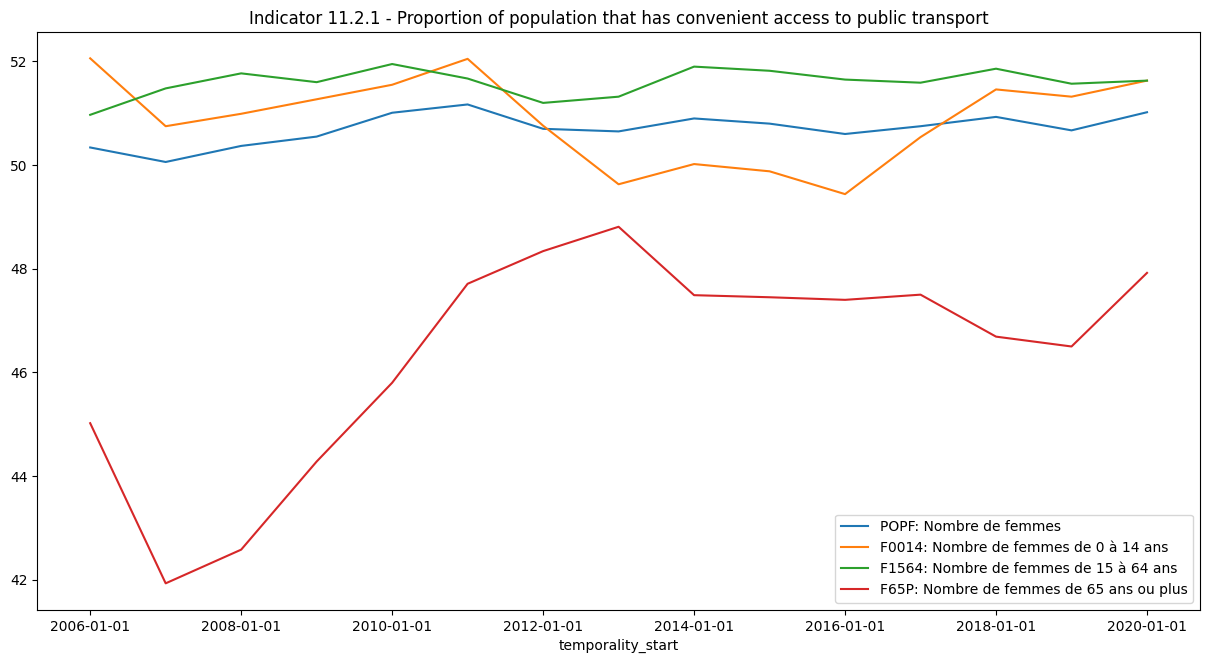

In [19]:
import matplotlib.pyplot as plt 
entity="GeographyArea"
source_metadata = benchmark[entity]

fig, ax = plt.subplots()
numpy.round(100 * entities_df[entity].loc[entities_df[entity][entity_filter[entity][0]].apply(lambda x: x in row_filter), collection + ["temporality_start"]].groupby(['temporality_start']).sum() / entities_df[entity][collection + ["temporality_start"]].groupby(['temporality_start']).sum(), 2).plot(figsize=(15, 7.5), title="Indicator 11.2.1 - Proportion of population that has convenient access to public transport", ax=ax)
ax.legend([f"""{column}: {source_metadata[column]["description"]}""" for column in collection])

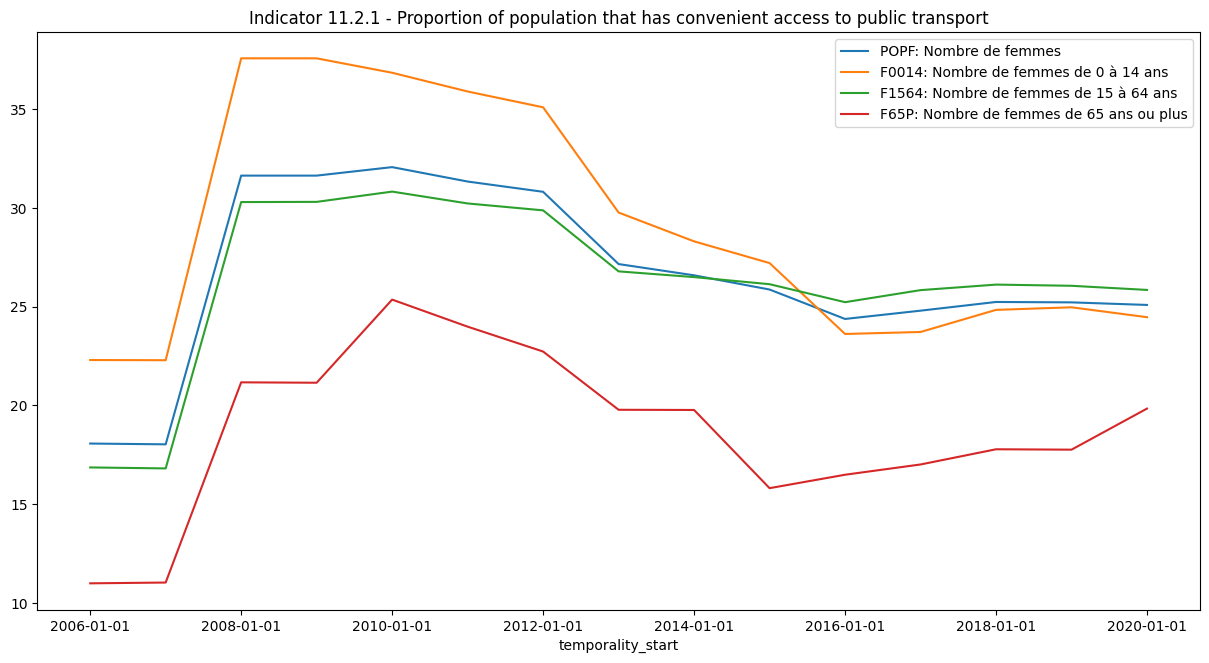

In [23]:
entity_filter = {
    "GeographyArea": ["geographyArea_0"],
    "PublicTransport": ["publicTransport_0"]
}
code_filter = {
    "GeographyArea": {
        "geographyArea_1": [77058]
    }
}

entities_df = {
    entity.split('.')[0]: pandas.read_csv(f'external_source/{entity}', sep=';') for entity in os.listdir("external_source/") if ".csv" in entity
}

for entity in entities_df:
    try:
        entities_df[entity] = entities_df[entity].loc[entities_df[entity].apply(lambda x: all([x[column] in code_filter[entity][column] for column in code_filter[entity]]), axis=1)].drop([column for column in entities_df[entity].columns if entity.lower() in column.lower() and column not in entity_filter[entity]], axis=1)
    except:
        pass

distanceTable = entities_df["GeographyArea"][entity_filter["GeographyArea"] + ['longitude', 'latitude']].merge(entities_df["PublicTransport"][entity_filter["PublicTransport"] + ['longitude', 'latitude']], how='cross').convert_dtypes()
distanceTable['distance'] = 6367 * 2 * numpy.arcsin(numpy.sqrt(numpy.sin((numpy.radians(distanceTable['latitude_x']) - numpy.radians(distanceTable['latitude_y']))/2)**2 + numpy.cos(numpy.radians(distanceTable['latitude_y'])) * numpy.cos(numpy.radians(distanceTable['latitude_x'])) * numpy.sin((numpy.radians(distanceTable['longitude_x']) - numpy.radians(distanceTable['longitude_y']))/2)**2))
distanceTable = distanceTable.drop_duplicates()
distanceTable = distanceTable.sort_values(entity_filter["GeographyArea"] + ['distance']).groupby(entity_filter["GeographyArea"]).nth[:1]

distance_threshold = 0.1
row_filter=distanceTable.loc[distanceTable.distance < distance_threshold, entity_filter["GeographyArea"][0]].unique()
row_filter

import matplotlib.pyplot as plt 
entity="GeographyArea"
source_metadata = benchmark[entity]

fig, ax = plt.subplots()
numpy.round(100 * entities_df[entity].loc[entities_df[entity][entity_filter[entity][0]].apply(lambda x: x in row_filter), collection + ["temporality_start"]].groupby(['temporality_start']).sum() / entities_df[entity][collection + ["temporality_start"]].groupby(['temporality_start']).sum(), 2).plot(figsize=(15, 7.5), title="Indicator 11.2.1 - Proportion of population that has convenient access to public transport", ax=ax)
ax.legend([f"""{column}: {source_metadata[column]["description"]}""" for column in collection])